In [1]:
import matplotlib.pyplot as plt
from reproject import reproject_interp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import Helioprojective, RotatedSunFrame, transform_with_sun_center
from sunpy.net import Fido, attrs as a

import datetime

import aiapy
from aiapy.calibrate import register, update_pointing, normalize_exposure

import warnings
warnings.filterwarnings("ignore")

print(sunpy.__version__)
print(aiapy.__version__)


2.1.2
0.6.0


In [2]:
def draw_nustar_fov(center_x, center_y, layers=[-100, 0, 100], color='red'):
    nustar_fov_side = 12*60 # arcseconds

    for diff in layers:
        # Translate to bottom left corner of rectangle
        bottom_left = ((center_x - nustar_fov_side/2 - diff)*u.arcsec, (center_y - nustar_fov_side/2 - diff)*u.arcsec)
        rect_bl = SkyCoord(*bottom_left, frame=out_warp.coordinate_frame)

        out_warp.draw_rectangle(rect_bl, width=(nustar_fov_side+2*diff)*u.arcsec, height=(nustar_fov_side+2*diff)*u.arcsec, color='red')
        

In [3]:
def aia_most_recent_map():
    current_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
    
    past = datetime.datetime.now()-datetime.timedelta(minutes=3)
    past_date = past.strftime("%Y-%m-%dT%H:%M:%S")

    startt = str(past_date)
    endt= str(current_date)

    result = Fido.search(a.Time(startt, endt),
                     a.Instrument("aia"), a.Wavelength(94*u.angstrom) )
    
    file_download = Fido.fetch(result[0, 0], site='ROB')
    aiamap = sunpy.map.Map(file_download[0])
    
    return(aiamap)


In [4]:
def reprojection(obstime:str, center_x, center_y, layers):
    aiamap = aia_most_recent_map()
    
    in_time = aiamap.date
    out_time = obstime
    out_frame = Helioprojective(observer='earth', obstime=out_time, rsun=aiamap.coordinate_frame.rsun)
    rot_frame = RotatedSunFrame(base=out_frame, rotated_time=in_time)

    out_shape = aiamap.data.shape
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(out_shape,
                                       out_center,
                                       scale=u.Quantity(aiamap.scale))
    out_wcs = WCS(header)
    out_wcs.coordinate_frame = rot_frame

    with transform_with_sun_center():
        arr, _ = reproject_interp(aiamap, out_wcs, out_shape)
    
    out_warp = sunpy.map.Map(arr, out_wcs)
    out_warp.plot_settings = aiamap.plot_settings

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(1, 2, 1, projection=aiamap)
    aiamap.plot( title=f'Original {in_time}')
    plt.colorbar()

    ax2 = fig.add_subplot(1, 2, 2, projection=out_warp)
    out_warp.plot(title=f"Reprojected to an Earth observer at {out_time}")
    plt.colorbar()
    
    nustar_fov_side = 12*60 # arcseconds

    for diff in layers:
        # Translate to bottom left corner of rectangle
        bottom_left = ((center_x - nustar_fov_side/2 - diff)*u.arcsec, (center_y - nustar_fov_side/2 - diff)*u.arcsec)
        rect_bl = SkyCoord(*bottom_left, frame=out_warp.coordinate_frame)

        out_warp.draw_rectangle(rect_bl, width=(nustar_fov_side+2*diff)*u.arcsec, height=(nustar_fov_side+2*diff)*u.arcsec, color='red')
                
    plt.show()

Files Downloaded:   0%|                                 | 0/1 [00:00<?, ?file/s]
aia20211101_212700_0094.fits:   0%|                 | 0.00/4.21M [00:00<?, ?B/s]
aia20211101_212700_0094.fits:   0%|          | 100/4.21M [00:00<3:38:01, 322B/s]
aia20211101_212700_0094.fits:   3%|▎        | 127k/4.21M [00:00<2:28:01, 460B/s]
aia20211101_212700_0094.fits:   7%|▋        | 303k/4.21M [00:00<1:39:09, 657B/s]
aia20211101_212700_0094.fits:  13%|█▏       | 543k/4.21M [00:00<1:05:09, 938B/s]
aia20211101_212700_0094.fits:  19%|█▋       | 796k/4.21M [00:00<42:28, 1.34kB/s]
aia20211101_212700_0094.fits:  30%|██▍     | 1.26M/4.21M [00:00<25:41, 1.91kB/s]
aia20211101_212700_0094.fits:  42%|███▎    | 1.77M/4.21M [00:00<14:53, 2.73kB/s]
aia20211101_212700_0094.fits:  57%|████▌   | 2.39M/4.21M [00:01<07:45, 3.90kB/s]
aia20211101_212700_0094.fits:  74%|█████▉  | 3.11M/4.21M [00:01<03:18, 5.58kB/s]
aia20211101_212700_0094.fits:  87%|██████▉ | 3.66M/4.21M [00:01<01:08, 7.96kB/s]
Files Downloaded: 100%|█████

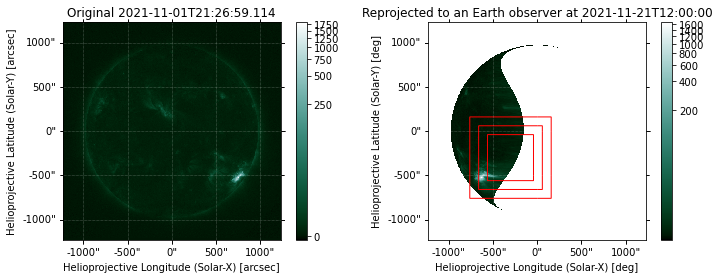


aia20211101_212700_0094.fits: 4.21MB [00:19, 11.4kB/s]                          

In [5]:
reprojection( '2021-11-21T12:00:00', -300, -300, [-100, 0, 100])